# gw2 1:2 Bifurcation Diagrams

SHOULD I BE USING THE TAYLOR EXPANSION IN PSI OF THE COUPLING TERM IN THE AVERAGED PSI EQUATION??????

I'm trying to figure out why the 1d bifurcation diagram in the full model is "flipped" compared to the reduced model.

It is unclear if it's in how I set up the model equations, or if there is a calculation error.

The homogeneous case works well enough. but with even a tiny bit of heterogeneity, the solutions don't match for small epsilon.

# Inits

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder to lib
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import gw2

from lib.util import (get_phase, freq_est, get_tongue_1d, pl_exist_1d, 
get_period, bif1d, follow_phase_diffs, phase_lock_r3d, follow_locking_3d,
load_phase_lock_r3d)

from lib.rhs import _redu_c,_full
from lib.rhs import _redu_3dc_gw as _redu_3dc

from lib.plot_util import add_diagram_1d_scatter, quick_plot_combined

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-8,'atol':1e-8,'method':'LSODA'}

In [3]:
pd1 = {'v1':.84,'v2':.42,'v4':.35,'v6':.35,'v8':1,
           'k1':1,'k2':1,'k3':.7,'k4':1,'k5':.7,
           'k6':1,'k7':.35,'k8':1,'K':0.5,'kc':1,
           'n':6,'L':0,'del':0,'om':1,'om_fix':1}

In [4]:
kws1 = {'var_names':['x','y','z','v'],
        'pardict':pd1,
        'rhs':gw2.rhs,
        'coupling':gw2.coupling,
        'init':np.array([.3882,.523,1.357,.4347,24.2]),
        'TN':10000,
        'trunc_order':3,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':0.5}

## Defs

In [5]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [6]:
eps_list12r = np.linspace(0.001,.1,50)
etup12 = (.001,.1,50)

In [7]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

## Initialize Response Functions

In [8]:
system1 = rsp(idx=0,model_name='gw0',**kws1)
system2 = rsp(idx=1,model_name='gw1',**kws1)

mkdir ./data/gw0/
* Loading LC data...
self.T 6.283185307179586 omfix 3.8590183230656914
* Loading monodromy...
* Floquet Exponent kappa =-0.15846659975489297
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/gw1/
* Loading LC data...
self.T 6.283185307179586 omfix 3.8590183230656914
* Loading monodromy...
* Floquet Exponent kappa =-0.15846659975489297
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


In [9]:
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',1),'_m':('om1',2),
        'NH':1024,'save_fig':False}

# del=0.0

In [10]:
del12_p0 = 0
a12_p0 = nm.nmCoupling(**kw_nm, del1=del12_p0)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...
* Loading H gw0, order=3...
* Loading H gw1, order=3...


## Get Branches Full

In [11]:
kw_p0 = {'a':a12_p0,'del1':del12_p0,'recompute':False,
        'bifdir':'bif1d_gw2/','_full_rhs':_full}

In [12]:
data_p0_list = []

In [13]:
in_dicts = [dict(init=0,eps_init=0.025,eps_final=0.078,deps=.01),
            dict(init=0,eps_init=0.025,eps_final=0.0001,deps=-.002)]
               #dict(init=2,eps_init=0.07,eps_final=0.11,deps=.01),
               #dict(init=2,eps_init=0.07,eps_final=0.05,deps=-.002),
               #dict(init=0,eps_init=0.025,eps_final=0.078,deps=.01)]

In [14]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p0)
    data_p0_list.append(dat)

fname1 td_branch_init=0_nm=12_del=0_ei=0.025_ef=0.078_de=0.01.txt
fname2 ts_branch_init=0_nm=12_del=0_ei=0.025_ef=0.078_de=0.01.txt
fname1 td_branch_init=0_nm=12_del=0_ei=0.025_ef=0.0001_de=-0.002.txt
fname2 ts_branch_init=0_nm=12_del=0_ei=0.025_ef=0.0001_de=-0.002.txt


In [15]:
# save hyperparameters
fname = kw_p0['bifdir']+'hyper_gw2_12_p0.txt'
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [16]:
data_r3d_p0_list = []

In [17]:
# find init for this branch
_,init = phase_lock_r3d([1.5,0,0],a12_p0,.05,_redu_3dc)
print(init)

t_diff 1.14045071630550138, Y=[ 1.14045072 -0.09542482 -0.08393199]                                              
[ 1.1405 -0.0954 -0.0839]


In [18]:
# bot 1f
dat = follow_locking_3d(init,a12_p0,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0_list.append(dat)

In [19]:
# bot 1b
dat = follow_locking_3d(init,a12_p0,(.05,.001,-.005),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0_list.append(dat)

In [20]:
# find init for this branch
_,init = phase_lock_r3d([4,0,0],a12_p0,.05,_redu_3dc)

t_diff 4.32058326981484609, Y=[ 4.32058327 -0.09687887 -0.08764864]                                              


In [21]:
# top 1f
dat = follow_locking_3d(init,a12_p0,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0_list.append(dat)

In [22]:
# top 1b
dat = follow_locking_3d(init,a12_p0,(.05,.001,-.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0_list.append(dat)

## Plot

eps_min 0.025


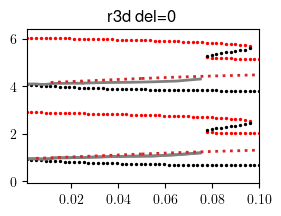

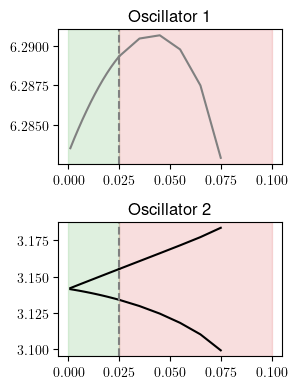

In [23]:
quick_plot_combined(a12_p0,
                    kw_f={'data_list':data_p0_list},
                    kw_r3d={'data_list':data_r3d_p0_list},
                    kw_r={'etup':etup12})

# del=0.0002

In [24]:
del12_p0002 = .0002
a12_p0002 = nm.nmCoupling(**kw_nm, del1=del12_p0002)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...
* Loading H gw0, order=3...
* Loading H gw1, order=3...


## Get Branches Full

In [25]:
kw_p0002 = {'a':a12_p0002,'del1':del12_p0002,
            'bifdir':'bif1d_gw2/','_full_rhs':_full}

In [26]:
data_p0002_list = []

In [27]:
in_dicts_p0002 = [dict(init=2,eps_init=0.02,eps_final=0.0005,deps=-.001),
                  dict(init=2,eps_init=0.02,eps_final=0.11,deps=.01),
                  dict(init=0,eps_init=0.02,eps_final=0.0005,deps=-.001),
                  dict(init=0,eps_init=0.02,eps_final=0.057,deps=.005)]

In [28]:
for i in range(len(in_dicts_p0002)):
    in1 = in_dicts_p0002[i]
    dat = follow_phase_diffs(max_iter=50,max_time=5000,**in1,**kw_p0002)
    data_p0002_list.append(dat)

fname1 td_branch_init=2_nm=12_del=0.0002_ei=0.02_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=2_nm=12_del=0.0002_ei=0.02_ef=0.0005_de=-0.001.txt
init [0.38546872 0.51935568 1.35648343 0.12629933 0.01385562 0.24045687 3.02733601 0.00741771 6.28809065]
eps iter 0 0.02                
t1,t2 1.710622540889711 6.317531424486555                               
t1,t2 4.839173660867482 6.317531424486555
periods [6.28637475 3.15878306 3.12759163]
eps iter 1 0.019                
t1,t2 1.5019518487993129 0.49345645225923773                             
t1,t2 4.638150569526207 0.49345645225923773
periods [6.28685096 3.1520309  3.13482295]
eps iter 2 0.018                
t1,t2 1.5011278055251942 0.49348535729804827                            
t1,t2 4.638255101605645 0.49348535729804827
periods [6.28673432 3.15148207 3.13524909]
eps iter 3 0.016999999999999998                
t1,t2 1.500323902371558 0.4935323245115101                              
t1,t2 4.638360504509966 0.4935323245115101
periods

In [29]:
# save hyperparameters
fname = kw_p0002['bifdir']+'hyper_gw2_12_p0002.txt'
hyp_inputs = np.zeros([len(in_dicts_p0002),4])
for i in range(len(in_dicts_p0002)):
    hyp_inputs[i,0] = in_dicts_p0002[i]['init']
    hyp_inputs[i,1] = in_dicts_p0002[i]['eps_init']
    hyp_inputs[i,2] = in_dicts_p0002[i]['eps_final']
    hyp_inputs[i,3] = in_dicts_p0002[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [30]:
data_r3d_p0002_list = []

In [31]:
# find init for this branch
_,init = load_phase_lock_r3d([1.5,0,0],a12_p0002,.05,_redu_3dc,
                            bifdir='gw2_bif1d')
print(init)

[ 1.2008 -0.0984 -0.0893]


In [32]:
# bot 1f
dat = follow_locking_3d(init,a12_p0002,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0002_list.append(dat)

In [33]:
# bot 1b
dat = follow_locking_3d(init,a12_p0002,(.05,.001,-.005),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0002_list.append(dat)

In [34]:
# find init for this branch
_,init = load_phase_lock_r3d([4,.1,.1],a12_p0002,.05,_redu_3dc,
                            bifdir='gw2_bif1d')

In [35]:
# top 1f
dat = follow_locking_3d(init,a12_p0002,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0002_list.append(dat)

In [36]:
# top 1b
dat = follow_locking_3d(init,a12_p0002,(.05,.001,-.002),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0002_list.append(dat)

## Plot

eps_min 0.02


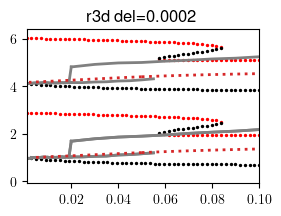

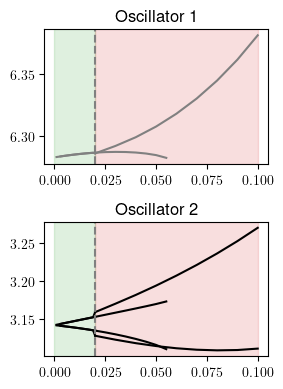

In [37]:
quick_plot_combined(a12_p0002,
                    kw_f={'data_list':data_p0002_list},
                    kw_r3d={'data_list':data_r3d_p0002_list},
                    kw_r={'etup':etup12})

# del=0.0003

In [38]:
del12_p0003 = .0003
a12_p0003 = nm.nmCoupling(**kw_nm, del1=del12_p0003)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H gw0, order=0...
* Computing H gw1, order=0...
* Computing H gw0, order=1...
* Computing H gw1, order=1...
* Computing H gw0, order=2...
* Computing H gw1, order=2...
* Computing H gw0, order=3...
* Computing H gw1, order=3...


* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...
* Loading H gw0, order=3...
* Loading H gw1, order=3...


## Get Branches Full

In [39]:
kw_p0003 = {'a':a12_p0003,'del1':del12_p0003,'bifdir':'bif1d_gw2/',
            '_full_rhs':_full}

In [40]:
data_p0003_list = []

In [41]:
in_dicts_p0003 = [dict(init=2,eps_init=0.02,eps_final=0.0005,deps=-.0005),
                  dict(init=2,eps_init=0.02,eps_final=0.11,deps=.01),
                  dict(init=0,eps_init=0.02,eps_final=0.0005,deps=-.001),
                  dict(init=0,eps_init=0.02,eps_final=0.045,deps=.001)]

In [42]:
for i in range(len(in_dicts_p0003)):
    in1 = in_dicts_p0003[i]
    dat = follow_phase_diffs(**in1,**kw_p0003)
    data_p0003_list.append(dat)

fname1 td_branch_init=2_nm=12_del=0.0003_ei=0.02_ef=0.0005_de=-0.0005.txt
fname2 ts_branch_init=2_nm=12_del=0.0003_ei=0.02_ef=0.0005_de=-0.0005.txt
fname1 td_branch_init=2_nm=12_del=0.0003_ei=0.02_ef=0.11_de=0.01.txt
fname2 ts_branch_init=2_nm=12_del=0.0003_ei=0.02_ef=0.11_de=0.01.txt
fname1 td_branch_init=0_nm=12_del=0.0003_ei=0.02_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=0_nm=12_del=0.0003_ei=0.02_ef=0.0005_de=-0.001.txt
fname1 td_branch_init=0_nm=12_del=0.0003_ei=0.02_ef=0.045_de=0.001.txt
fname2 ts_branch_init=0_nm=12_del=0.0003_ei=0.02_ef=0.045_de=0.001.txt


In [43]:
# save hyperparameters
fname = kw_p0003['bifdir']+'hyper_gw2_12_p0003.txt'
hyp_inputs = np.zeros([len(in_dicts_p0003),4])
for i in range(len(in_dicts_p0003)):
    hyp_inputs[i,0] = in_dicts_p0003[i]['init']
    hyp_inputs[i,1] = in_dicts_p0003[i]['eps_init']
    hyp_inputs[i,2] = in_dicts_p0003[i]['eps_final']
    hyp_inputs[i,3] = in_dicts_p0003[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [44]:
data_r3d_p0003_list = []

In [45]:
# find init for this branch
_,init = phase_lock_r3d([1.5,0,0],a12_p0003,.05,_redu_3dc)
print(init)

t_diff 1.23676401827389282, Y=[ 1.23676402 -0.09958746 -0.09215801]                                              
[ 1.2368 -0.0996 -0.0922]


t_diff 1.2367640182738928
[ 1.2368 -0.0996 -0.0922]


In [46]:
# bot 1f
dat = follow_locking_3d(init,a12_p0003,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p0003_list.append(dat)

eps iter 0 0.05                
t_diff 1.23676401827388489, Y=[ 1.23676402 -0.09958746 -0.09215801]                                              
eps iter 1 0.060000000000000005                
t_diff 1.27566279293920710, Y=[ 1.27566279 -0.12021455 -0.11333771]                                              
eps iter 2 0.07                
t_diff 1.30870614624357561, Y=[ 1.30870615 -0.1408221  -0.1347435 ]                                              
eps iter 3 0.08000000000000002                
t_diff 1.33680300336052161, Y=[ 1.336803   -0.1614336  -0.15627171]                                              
eps iter 4 0.09000000000000001                
t_diff 1.36110353910692622, Y=[ 1.36110354 -0.18207519 -0.17789398]                                              
eps iter 5 0.1                
t_diff 1.38259589644980573, Y=[ 1.3825959  -0.20275976 -0.19960879]                                              


t_diff 1.275662792939207
eps iter 2 0.07                


t_diff 1.3087061462435756
eps iter 3 0.08000000000000002                


t_diff 1.3368030033605216
eps iter 4 0.09000000000000001                


t_diff 1.3611035391069262
eps iter 5 0.1                


t_diff 1.3825958964498057


In [47]:
# bot 1b
dat = follow_locking_3d(init,a12_p0003,(.05,.001,-.01),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p0003_list.append(dat)

eps iter 0 0.05                
t_diff 1.23676401827388489, Y=[ 1.23676402 -0.09958746 -0.09215801]                                              
eps iter 1 0.04                
t_diff 1.19213081371775460, Y=[ 1.19213081 -0.07896587 -0.07144389]                                              
eps iter 2 0.03                
t_diff 1.14347676507899411, Y=[ 1.14347677 -0.05847816 -0.05156769]                                              
eps iter 3 0.019999999999999997                
t_diff 1.09350191103358333, Y=[ 1.09350191 -0.03834684 -0.03290725]                                              
eps iter 4 0.009999999999999995                
t_diff 1.04459061573465873, Y=[ 1.04459062 -0.01880095 -0.01569826]                                              


t_diff 1.1921308137177546
eps iter 2 0.03                


t_diff 1.143476765078994
eps iter 3 0.019999999999999997                


t_diff 1.0935019110335833
eps iter 4 0.009999999999999995                


t_diff 1.0445906157346587


In [48]:
# # find init for this branch
# _,init = phase_lock_r3d([2.25,0,0],a12_p0003,.02,_redu_3dc)

In [49]:
# # top 1f
# dat = follow_locking_3d(init,a12_p0003,(.02,.1,.01),
#                         rhs=_redu_3dc,recompute=True)
# data_r3d_p0003_list.append(dat)

In [50]:
# # top 1b
# dat = follow_locking_3d(init,a12_p0003,(.02,.001,-.005),
#                         rhs=_redu_3dc,recompute=True)
# data_r3d_p0003_list.append(dat)

## Plot

eps_min 0.012999999999999994


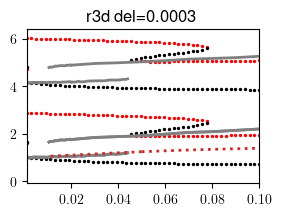

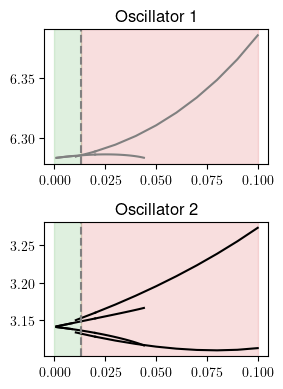

In [51]:
quick_plot_combined(a12_p0003,
                    kw_f={'data_list':data_p0003_list},
                    kw_r3d={'data_list':data_r3d_p0003_list},
                    kw_r={'etup':etup12})

# del=0.0004

In [52]:
del12_p0004 = .0004
a12_p0004 = nm.nmCoupling(**kw_nm, del1=del12_p0004)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H gw0, order=0...
* Computing H gw1, order=0...
* Computing H gw0, order=1...
* Computing H gw1, order=1...
* Computing H gw0, order=2...
* Computing H gw1, order=2...
* Computing H gw0, order=3...
* Computing H gw1, order=3...


* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...
* Loading H gw0, order=3...
* Loading H gw1, order=3...


## Get Branches Full

In [53]:
kw_p0004 = {'a':a12_p0004,'del1':del12_p0004,'bifdir':'bif1d_gw2/',
            '_full_rhs':_full}

In [54]:
data_p0004_list = []

In [55]:
in_dicts = [dict(init=2,eps_init=0.02,eps_final=0.0005,deps=-.001),
              dict(init=2,eps_init=0.02,eps_final=0.11,deps=.01),
              dict(init=0,eps_init=0.02,eps_final=0.0005,deps=-.001),
              dict(init=0,eps_init=0.02,eps_final=0.04,deps=.002)]

In [56]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p0004)
    data_p0004_list.append(dat)
fname = kw_p0004['bifdir']+'hyper_gw2_12_p0004.txt'

fname1 td_branch_init=2_nm=12_del=0.0004_ei=0.02_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=2_nm=12_del=0.0004_ei=0.02_ef=0.0005_de=-0.001.txt
init [0.38616119 0.51981697 1.35620943 0.12650421 0.02116865 0.32584319 3.11836355 0.01187601 6.29422919]
eps iter 0 0.02                
t1,t2 1.851004958342362 6.319522784577234                               
t1,t2 4.977915752224454 6.319522784577234
periods [6.29017371 3.1610182  3.12915548]
eps iter 1 0.019                
t1,t2 1.8466273525250467 6.324808162214683                              
t1,t2 4.971934703751556 6.324808162214683
periods [6.28965593 3.15995427 3.12969841]
eps iter 2 0.018                
t1,t2 1.8432666595081029 6.346581553460639                              
t1,t2 4.964338895285238 6.346581553460639
periods [6.28914856 3.1589022  3.13024729]
eps iter 3 0.016999999999999998                
t1,t2 1.8376185959279372 6.3470559082571665                             
t1,t2 4.965355972232292 6.3470559082571665
periods [6.2

In [57]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Plot

eps_min 0.012999999999999994


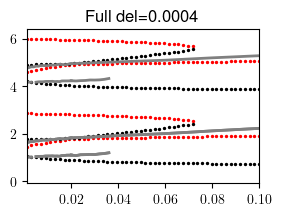

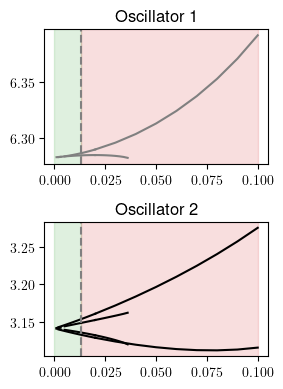

In [58]:
quick_plot_combined(a12_p0004,
                    kw_f={'data_list':data_p0004_list},
                    #kw_r3d={'data_list':data_r3d_p0004_list},
                    kw_r={'etup':etup12})

# del=0.0005

In [59]:
del12_p0005 = .0005
a12_p0005 = nm.nmCoupling(**kw_nm, del1=del12_p0005)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H gw0, order=0...
* Computing H gw1, order=0...
* Computing H gw0, order=1...
* Computing H gw1, order=1...
* Computing H gw0, order=2...
* Computing H gw1, order=2...
* Computing H gw0, order=3...
* Computing H gw1, order=3...


* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...
* Loading H gw0, order=3...
* Loading H gw1, order=3...


## Get Branches Full

In [60]:
kw_p0005 = {'a':a12_p0005,'del1':del12_p0005,'bifdir':'bif1d_gw2/',
            '_full_rhs':_full}

In [61]:
data_p0005_list = []

In [62]:
in_dicts = [dict(init=2,eps_init=0.02,eps_final=0.0005,deps=-.002),
            dict(init=2,eps_init=0.02,eps_final=0.11,deps=.01),
            dict(init=0,eps_init=0.025,eps_final=0.0005,deps=-.002)]

In [63]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p0005)
    data_p0005_list.append(dat)
fname = kw_p0005['bifdir']+'hyper_gw2_12_p0005.txt'

fname1 td_branch_init=2_nm=12_del=0.0005_ei=0.02_ef=0.0005_de=-0.002.txt
fname2 ts_branch_init=2_nm=12_del=0.0005_ei=0.02_ef=0.0005_de=-0.002.txt
fname1 td_branch_init=2_nm=12_del=0.0005_ei=0.02_ef=0.11_de=0.01.txt
fname2 ts_branch_init=2_nm=12_del=0.0005_ei=0.02_ef=0.11_de=0.01.txt
fname1 td_branch_init=0_nm=12_del=0.0005_ei=0.025_ef=0.0005_de=-0.002.txt
fname2 ts_branch_init=0_nm=12_del=0.0005_ei=0.025_ef=0.0005_de=-0.002.txt


In [64]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [65]:
data_r3d_p0005_list = []

In [66]:
# find init for this branch
_,init = phase_lock_r3d([1.5,0,0],a12_p0005,.05,_redu_3dc)
print(init)

t_diff 1.32934444970619813, Y=[ 1.32934445 -0.10084999 -0.09816996]                                              
[ 1.3293 -0.1008 -0.0982]


t_diff 1.329344449706198
[ 1.3293 -0.1008 -0.0982]


In [67]:
# bot 1f
dat = follow_locking_3d(init,a12_p0005,(.05,.1,.01),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p0005_list.append(dat)

eps iter 0 0.05                
t_diff 1.32934444970619150, Y=[ 1.32934445 -0.10084999 -0.09816996]                                              
eps iter 1 0.060000000000000005                
t_diff 1.36003469724829629, Y=[ 1.3600347  -0.12114445 -0.1194483 ]                                              
eps iter 2 0.07                
t_diff 1.38377258222697511, Y=[ 1.38377258 -0.14154053 -0.1407471 ]                                              
eps iter 3 0.08000000000000002                
t_diff 1.40342782729701112, Y=[ 1.40342783 -0.16206342 -0.16211859]                                              
eps iter 4 0.09000000000000001                
t_diff 1.42063072167859943, Y=[ 1.42063072 -0.18270981 -0.18359455]                                              


t_diff 1.3600346972482962
eps iter 2 0.07                


t_diff 1.383772582226975
eps iter 3 0.08000000000000002                
t_diff 1.403427827297011
eps iter 4 0.09000000000000001                


t_diff 1.4206307216785994


In [68]:
# bot 1b
dat = follow_locking_3d(init,a12_p0005,(.05,.001,-.002),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p0005_list.append(dat)

eps iter 0 0.05                
t_diff 1.32934444970619150, Y=[ 1.32934445 -0.10084999 -0.09816996]                                              
eps iter 1 0.048                
t_diff 1.32201232287463708, Y=[ 1.32201232 -0.09679705 -0.09391228]                                              
eps iter 2 0.046                
t_diff 1.31419640331788883, Y=[ 1.3141964  -0.0927438  -0.08965385]                                              
eps iter 3 0.044                
t_diff 1.30586411404894153, Y=[ 1.30586411 -0.08868899 -0.08539536]                                              
eps iter 4 0.041999999999999996                
t_diff 1.29698969350391053, Y=[ 1.29698969 -0.08463127 -0.08113811]                                              
eps iter 5 0.039999999999999994                
t_diff 1.28755763881343093, Y=[ 1.28755764 -0.08056931 -0.07688416]                                              
eps iter 6 0.03799999999999999                
t_diff 1.27756612574880313, Y=[ 1.27756613

t_diff 1.3141964033178888
eps iter 3 0.044                


t_diff 1.3058641140489415
eps iter 4 0.041999999999999996                


t_diff 1.2969896935039105
eps iter 5 0.039999999999999994                


t_diff 1.2875576388134309
eps iter 6 0.03799999999999999                
t_diff 1.277566125748803
eps iter 7 0.03599999999999999                


t_diff 1.2670297745732484
eps iter 8 0.03399999999999999                


t_diff 1.2559810564150562
eps iter 9 0.03199999999999999                


t_diff 1.2444697857479041
eps iter 10 0.029999999999999985                
t_diff 1.2325605361057588
eps iter 11 0.027999999999999983                


t_diff 1.2203283359086603
eps iter 12 0.02599999999999998                
t_diff 1.20785342953919
eps iter 13 0.02399999999999998                


t_diff 1.1952160521061845
eps iter 14 0.021999999999999978                


t_diff 1.1824920209895644
eps iter 15 0.019999999999999976                
t_diff 1.1697496046729283
eps iter 16 0.017999999999999974                


t_diff 1.1570477591444301
eps iter 17 0.015999999999999973                
t_diff 1.144435550247343
eps iter 18 0.01399999999999997                


t_diff 1.131952449158
eps iter 19 0.011999999999999969                


t_diff 1.1196291739304407
eps iter 20 0.009999999999999967                
t_diff 1.1074888035627006
eps iter 21 0.007999999999999965                


t_diff 1.0955479681000133
eps iter 22 0.005999999999999964                
t_diff 1.083817991343229
eps iter 23 0.003999999999999962                


t_diff 1.072305919828352
eps iter 24 0.00199999999999996                


t_diff 1.0610154109791874


In [69]:
# find init for this branch
_,init = phase_lock_r3d([1.7,0,0], a12_p0005, .02, 
                        _redu_3dc,maxiter=1000)

t_diff 2.85417418478798851, Y=[2.85417418 0.00499587 0.0064883 ]                                                 


t_diff 2.8541741847879885


In [70]:
# top 1f
dat = follow_locking_3d(init,a12_p0005,(.02,.1,.002),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p0005_list.append(dat)

eps iter 0 0.02                
t_diff 2.85417418478798811, Y=[2.85417418 0.00499587 0.0064883 ]                                              
eps iter 1 0.022                
t_diff 2.85402475877803108, Y=[2.85402476 0.00549965 0.00714176]                                              
eps iter 2 0.023999999999999997                
t_diff 2.85387502910684188, Y=[2.85387503 0.0060042  0.00779609]                                              
eps iter 3 0.025999999999999995                
t_diff 2.85372499512930848, Y=[2.853725   0.00650953 0.00845126]                                              
eps iter 4 0.027999999999999994                
t_diff 2.85357465619210838, Y=[2.85357466 0.00701562 0.00910729]                                              
eps iter 5 0.029999999999999992                
t_diff 2.85342401163363458, Y=[2.85342401 0.00752249 0.00976418]                                              
eps iter 6 0.03199999999999999                
t_diff 2.85327306078344308, Y=

t_diff 2.854024758778031
eps iter 2 0.023999999999999997                


t_diff 2.8538750291068418
eps iter 3 0.025999999999999995                


t_diff 2.8537249951293084
eps iter 4 0.027999999999999994                


t_diff 2.8535746561921083
eps iter 5 0.029999999999999992                


t_diff 2.8534240116336345
eps iter 6 0.03199999999999999                


t_diff 2.853273060783443
eps iter 7 0.03399999999999999                


t_diff 2.8531218029625913
eps iter 8 0.03599999999999999                


t_diff 2.8529702374833024
eps iter 9 0.037999999999999985                


t_diff 2.852818363648513
eps iter 10 0.03999999999999998                


t_diff 2.8526661807518106
eps iter 11 0.04199999999999998                


t_diff 2.852513688076994
eps iter 12 0.043999999999999984                


t_diff 2.85236088489753
eps iter 13 0.04599999999999998                


t_diff 2.852207770476809
eps iter 14 0.04799999999999997                


t_diff 2.8520543440675654
eps iter 15 0.049999999999999975                


t_diff 2.851900604911774
eps iter 16 0.05199999999999998                


t_diff 2.8517465522402574
eps iter 17 0.05399999999999998                


t_diff 2.8515921852724797
eps iter 18 0.055999999999999966                


t_diff 2.8514375032161325
eps iter 19 0.05799999999999997                


t_diff 2.851282505266846
eps iter 20 0.05999999999999997                


t_diff 2.8511271906090037
eps iter 21 0.06199999999999997                


t_diff 2.8509715584140807
eps iter 22 0.06399999999999996                


t_diff 2.8508156078411435
eps iter 23 0.06599999999999996                


t_diff 2.8506593380362837
eps iter 24 0.06799999999999996                


t_diff 2.8505027481294825
eps iter 25 0.06999999999999997                
t_diff 2.8503458372375308
eps iter 26 0.07199999999999995                


t_diff 2.8501886044624807
eps iter 27 0.07399999999999995                


t_diff 2.850031048891234
eps iter 28 0.07599999999999996                


t_diff 2.8498731695991797
eps iter 29 0.07799999999999996                


t_diff 2.8497149656455085
eps iter 30 0.07999999999999995                


t_diff 2.849556436074193
eps iter 31 0.08199999999999995                


t_diff 2.8493975799137354
eps iter 32 0.08399999999999995                


t_diff 2.8492383961742234
eps iter 33 0.08599999999999995                


t_diff 2.849078883849839
eps iter 34 0.08799999999999995                


t_diff 2.8489190419176165
eps iter 35 0.08999999999999994                


t_diff 2.848758869336951
eps iter 36 0.09199999999999994                


t_diff 2.84859836504943
eps iter 37 0.09399999999999994                


t_diff 2.8484375279782617
eps iter 38 0.09599999999999993                


t_diff 2.8482763570273852
eps iter 39 0.09799999999999993                


t_diff 2.848114851082259


In [71]:
# top 1b
dat = follow_locking_3d(init,a12_p0005,(.02,.001,-.002),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p0005_list.append(dat)

eps iter 0 0.02                
t_diff 2.85417418478798811, Y=[2.85417418 0.00499587 0.0064883 ]                                              
eps iter 1 0.018000000000000002                
t_diff 2.85432330777373188, Y=[2.85432331 0.00449286 0.00583568]                                              
eps iter 2 0.016000000000000004                
t_diff 2.85447212836488708, Y=[2.85447213 0.00399061 0.0051839 ]                                              
eps iter 3 0.014000000000000005                
t_diff 2.85462064718354908, Y=[2.85462065 0.00348913 0.00453298]                                              
eps iter 4 0.012000000000000007                
t_diff 2.85476886484471408, Y=[2.85476886 0.00298841 0.00388289]                                              
eps iter 5 0.010000000000000009                
t_diff 2.85491678195632308, Y=[2.85491678e+00 2.48844804e-03 3.23364981e-03]                                              
eps iter 6 0.00800000000000001                
t_d

t_diff 2.8543233077737318
eps iter 2 0.016000000000000004                


t_diff 2.854472128364887
eps iter 3 0.014000000000000005                


t_diff 2.854620647183549
eps iter 4 0.012000000000000007                


t_diff 2.854768864844714
eps iter 5 0.010000000000000009                


t_diff 2.854916781956323
eps iter 6 0.00800000000000001                


t_diff 2.8550643991195725
eps iter 7 0.006000000000000012                


t_diff 2.8552117169289244
eps iter 8 0.004000000000000014                


t_diff 2.8553587359725157
eps iter 9 0.0020000000000000157                


t_diff 2.8555054568321347


## Plot

eps_min 0.014000000000000005


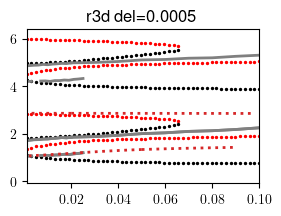

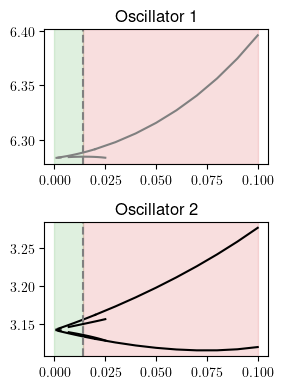

In [72]:
quick_plot_combined(a12_p0005,
                    kw_f={'data_list':data_p0005_list},
                    kw_r3d={'data_list':data_r3d_p0005_list},
                    kw_r={'etup':etup12})

# del=0.00055

In [73]:
del12_p00055 = .00055
a12_p00055 = nm.nmCoupling(**kw_nm, del1=del12_p00055)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H gw0, order=0...
* Computing H gw1, order=0...
* Computing H gw0, order=1...
* Computing H gw1, order=1...
* Computing H gw0, order=2...
* Computing H gw1, order=2...
* Computing H gw0, order=3...
* Computing H gw1, order=3...


* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...
* Loading H gw0, order=3...
* Loading H gw1, order=3...


## Get Branches Full

In [74]:
kw_p00055 = {'a':a12_p00055,'del1':del12_p00055,'bifdir':'bif1d_gw2/',
             '_full_rhs':_full}

In [75]:
data_p00055_list = []

In [76]:
in_dicts = [dict(init=2,eps_init=0.02,eps_final=0.0005,deps=-.001),
            dict(init=2,eps_init=0.02,eps_final=0.11,deps=.01),
            dict(init=0,eps_init=0.025,eps_final=0.0005,deps=-.002)]

In [77]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p00055)
    data_p00055_list.append(dat)
fname = kw_p00055['bifdir']+'hyper_gw2_12_p00055.txt'

fname1 td_branch_init=2_nm=12_del=0.00055_ei=0.02_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=2_nm=12_del=0.00055_ei=0.02_ef=0.0005_de=-0.001.txt
init [0.38621595 0.51984701 1.35618987 0.12651926 0.02232379 0.33699299 3.12388767 0.0125725  6.29487155]
eps iter 0 0.02                
t1,t2 1.8762441548681097 6.313767444868709                              
t1,t2 5.015238866257828 6.313767444868709
periods [6.29183939 3.16191042 3.12993176]
eps iter 1 0.019                
t1,t2 1.8820018052942151 6.307916334346759                              
t1,t2 5.010368336456543 6.307916334346759
periods [6.29125954 3.16081794 3.1304425 ]
eps iter 2 0.018                
t1,t2 1.8774014604803102 6.322468279785044                              
t1,t2 5.0030725085160395 6.322468279785044
periods [6.29069053 3.15973344 3.13095754]
eps iter 3 0.016999999999999998                
t1,t2 1.8747477739551637 6.314624036585068                              
t1,t2 5.007347899141385 6.314624036585068
periods [6

In [78]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Plot

eps_min 0.012999999999999994


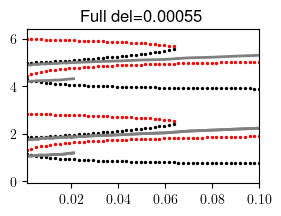

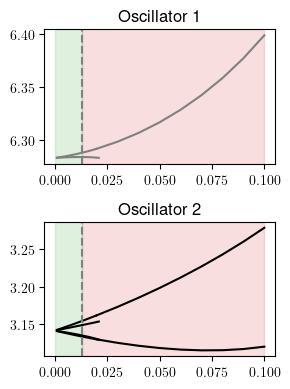

In [79]:
quick_plot_combined(a12_p00055,
                    kw_f={'data_list':data_p00055_list},
                    #kw_r3d={'data_list':data_r3d_p00055_list},
                    kw_r={'etup':etup12})

# del=0.0006

In [80]:
del12_p0006 = .0006
a12_p0006 = nm.nmCoupling(**kw_nm, del1=del12_p0006)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H gw0, order=0...
* Computing H gw1, order=0...
* Computing H gw0, order=1...
* Computing H gw1, order=1...
* Computing H gw0, order=2...
* Computing H gw1, order=2...
* Computing H gw0, order=3...
* Computing H gw1, order=3...


* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...
* Loading H gw0, order=3...
* Loading H gw1, order=3...


## Get Branches Full

In [81]:
kw_p0006 = {'a':a12_p0006,'del1':del12_p0006,'bifdir':'bif1d_gw2/',
            '_full_rhs':_full}

In [82]:
data_p0006_list = []

In [83]:
in_dicts = [dict(init=2,eps_init=0.02,eps_final=0.0005,deps=-.001),
            dict(init=2,eps_init=0.02,eps_final=0.11,deps=.01),
            dict(init=1,eps_init=0.01,eps_final=0.0005,deps=-.001)]

In [84]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p0006)
    data_p0006_list.append(dat)
fname = kw_p0006['bifdir']+'hyper_gw2_12_p0006.txt'

fname1 td_branch_init=2_nm=12_del=0.0006_ei=0.02_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=2_nm=12_del=0.0006_ei=0.02_ef=0.0005_de=-0.001.txt
init [0.38623412 0.51986572 1.35619286 0.12652557 0.02271951 0.34070407 3.12544419 0.01281081 6.29511842]
eps iter 0 0.02                
t1,t2 1.8997340716766897 6.326422806186744                              
t1,t2 5.027601769535487 6.326422806186744
periods [6.29233395 3.1621679  3.13016725]
eps iter 1 0.019                
t1,t2 1.8958271940293057 6.326569883571398                              
t1,t2 5.017512808821341 6.326569883571398
periods [6.29172971 3.16106532 3.13066793]
eps iter 2 0.018                
t1,t2 1.8919578944532025 6.325913977220194                              
t1,t2 5.014625266271065 6.325913977220194
periods [6.29114358 3.15996871 3.13117401]
eps iter 3 0.016999999999999998                
t1,t2 1.8881241286063315 6.316360732272168                              
t1,t2 5.017769723509946 6.316360732272168
periods [6.29

In [85]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Plot

eps_min 0.012999999999999994


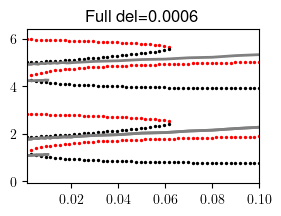

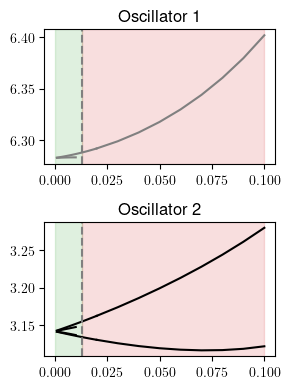

In [86]:
quick_plot_combined(a12_p0006,
                    kw_f={'data_list':data_p0006_list},
                    #kw_r3d={'data_list':data_r3d_p0006_list},
                    kw_r={'etup':etup12})

# del=0.0007

In [87]:
del12_p0007 = .0007
a12_p0007 = nm.nmCoupling(**kw_nm, del1=del12_p0007)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...
* Loading H gw0, order=3...
* Loading H gw1, order=3...


* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...
* Loading H gw0, order=3...
* Loading H gw1, order=3...


## Get Branches Full

In [88]:
kw_p0007 = {'a':a12_p0007,'del1':del12_p0007,'bifdir':'bif1d_gw2/',
            '_full_rhs':_full}

In [89]:
data_p0007_list = []

In [90]:
in_dicts = [dict(init=2,eps_init=0.02,eps_final=0.0005,deps=-.001),
            dict(init=2,eps_init=0.02,eps_final=0.11,deps=.01),
            dict(init=1,eps_init=0.005,eps_final=0.0005,deps=-.001)]

In [91]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p0007)
    data_p0007_list.append(dat)
fname = kw_p0007['bifdir']+'hyper_gw2_12_p0007.txt'

fname1 td_branch_init=2_nm=12_del=0.0007_ei=0.02_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=2_nm=12_del=0.0007_ei=0.02_ef=0.0005_de=-0.001.txt
fname1 td_branch_init=2_nm=12_del=0.0007_ei=0.02_ef=0.11_de=0.01.txt
fname2 ts_branch_init=2_nm=12_del=0.0007_ei=0.02_ef=0.11_de=0.01.txt
fname1 td_branch_init=1_nm=12_del=0.0007_ei=0.005_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=1_nm=12_del=0.0007_ei=0.005_ef=0.0005_de=-0.001.txt


In [92]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [93]:
data_r3d_p0007_list = []

In [94]:
# find init for this branch
_,init = phase_lock_r3d([1,0,0],a12_p0007,.05,_redu_3dc)
print(init)

t_diff 1.47875681729214110, Y=[ 1.47875682 -0.09741839 -0.10321932]                                              
[ 1.4788 -0.0974 -0.1032]


In [95]:
# bot 1f
dat = follow_locking_3d(init,a12_p0007,(.05,.1,.01),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p0007_list.append(dat)

eps iter 0 0.05                
t_diff 1.47875681729214978, Y=[ 1.47875682 -0.09741839 -0.10321932]                                              
eps iter 1 0.060000000000000005                
t_diff 1.47055863382646-08, Y=[ 1.47055863 -0.1184887  -0.1240846 ]                                              
eps iter 2 0.07                
t_diff 1.47168920599069310, Y=[ 1.47168921 -0.13940856 -0.14513806]                                              
eps iter 3 0.08000000000000002                
t_diff 1.47666018143861312, Y=[ 1.47666018 -0.16035689 -0.16637377]                                              
eps iter 4 0.09000000000000001                
t_diff 1.48362185148469813, Y=[ 1.48362185 -0.18137752 -0.18777925]                                              


t_diff 1.471689205990693
eps iter 3 0.08000000000000002                


t_diff 1.476660181438613
eps iter 4 0.09000000000000001                


t_diff 1.483621851484698


In [96]:
# bot 1b
dat = follow_locking_3d(init,a12_p0007,(.05,.001,-.002),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p0007_list.append(dat)

eps iter 0 0.05                
t_diff 1.47875681729214978, Y=[ 1.47875682 -0.09741839 -0.10321932]                                              
eps iter 1 0.048                
t_diff 1.48283597094684553, Y=[ 1.48283597 -0.09313766 -0.09906522]                                              
eps iter 2 0.046                
t_diff 1.48839614051263113, Y=[ 1.48839614 -0.08880821 -0.09491296]                                              
eps iter 3 0.044                
t_diff 1.49598792035782112, Y=[ 1.49598792 -0.0844069  -0.09075634]                                              
eps iter 4 0.041999999999999996                
t_diff 1.50637918012531321, Y=[ 1.50637918 -0.07990025 -0.08658303]                                              
eps iter 5 0.039999999999999994                
t_diff 1.52050164179818410, Y=[ 1.52050164 -0.0752461  -0.08236982]                                              
eps iter 6 0.03799999999999999                
t_diff 1.53902693548226520, Y=[ 1.53902694

t_diff 1.4828359709468455
eps iter 2 0.046                


t_diff 1.488396140512631
eps iter 3 0.044                


t_diff 1.495987920357821
eps iter 4 0.041999999999999996                


t_diff 1.5063791801253132
eps iter 5 0.039999999999999994                


t_diff 1.520501641798184
eps iter 6 0.03799999999999999                


t_diff 1.5390269354822652
eps iter 7 0.03599999999999999                


t_diff 1.561426432405624
eps iter 8 0.03399999999999999                


t_diff 1.5856161592739342
eps iter 9 0.03199999999999999                


t_diff 1.6093198742513681
eps iter 10 0.029999999999999985                


t_diff 1.6313113196719382
eps iter 11 0.027999999999999983                


t_diff 1.6512905738710486
eps iter 12 0.02599999999999998                


t_diff 1.6693745011963237
eps iter 13 0.02399999999999998                


t_diff 1.6857981453139912
eps iter 14 0.021999999999999978                


t_diff 1.700800047207308
eps iter 15 0.019999999999999976                


t_diff 1.7145887042091228
eps iter 16 0.017999999999999974                


t_diff 1.7273377073078346
eps iter 17 0.015999999999999973                


t_diff 1.739189490686203
eps iter 18 0.01399999999999997                


t_diff 1.750260821105553
eps iter 19 0.011999999999999969                


t_diff 1.760647902522884
eps iter 20 0.009999999999999967                


t_diff 1.770430589591435
eps iter 21 0.007999999999999965                
t_diff 1.7796757188420782
eps iter 22 0.005999999999999964                


t_diff 1.7884397026700798
eps iter 23 0.003999999999999962                
t_diff 1.79677054360923
eps iter 24 0.00199999999999996                


t_diff 1.8047094033385667


In [97]:
# find init for this branch
_,init = phase_lock_r3d([5,0,0],a12_p0007,.005,_redu_3dc)

t_diff 4.97935372464916312, Y=[ 4.97935372 -0.00619541 -0.00854558]                                              


In [98]:
# top 1f
dat = follow_locking_3d(init,a12_p0007,(.005,.009,.0005),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p0007_list.append(dat)

eps iter 0 0.005                
t_diff 4.97935372464916609, Y=[ 4.97935372 -0.00619541 -0.00854558]                                              
eps iter 1 0.0055                
t_diff 4.97772868389300511, Y=[ 4.97772868 -0.00683867 -0.00941952]                                              
eps iter 2 0.005999999999999999                
t_diff 4.97608881340422911, Y=[ 4.97608881 -0.00748646 -0.0102971 ]                                              
eps iter 3 0.006499999999999999                
t_diff 4.97443386651519-11, Y=[ 4.97443387 -0.00813882 -0.01117834]                                              
eps iter 4 0.006999999999999998                
t_diff 4.97276359126131911, Y=[ 4.97276359 -0.00879583 -0.01206327]                                              
eps iter 5 0.007499999999999998                
t_diff 4.97107773027645511, Y=[ 4.97107773 -0.00945753 -0.01295193]                                              
eps iter 6 0.007999999999999997                
t_diff 4.

t_diff 1.190981008396195
eps iter 2 0.005999999999999999                


t_diff 1.1976290966828003
eps iter 3 0.006499999999999999                


t_diff 1.2047577809790815
eps iter 4 0.006999999999999998                


t_diff 1.2125356063219048
eps iter 5 0.007499999999999998                


t_diff 1.2212683913865034
eps iter 6 0.007999999999999997                


t_diff 1.2316396551953357
eps iter 7 0.008499999999999997                


t_diff 1.246184136557396


In [99]:
# top 1b
dat = follow_locking_3d(init,a12_p0007,(.005,.001,-.001),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p0007_list.append(dat)

eps iter 0 0.005                
t_diff 4.97935372464916609, Y=[ 4.97935372 -0.00619541 -0.00854558]                                              
eps iter 1 0.004                
t_diff 4.98256027779853610, Y=[ 4.98256028e+00 -4.92224800e-03 -6.80849795e-03]                                              
eps iter 2 0.003                
t_diff 4.98571034434219510, Y=[ 4.98571034e+00 -3.66653456e-03 -5.08561968e-03]                                              
eps iter 3 0.002                
t_diff 4.98880571786917850, Y=[ 4.98880572e+00 -2.42785513e-03 -3.37672368e-03]                                              


t_diff 1.1730306407149376
eps iter 2 0.003                


t_diff 1.1622339011474456
eps iter 3 0.002                


t_diff 1.1521103909015558


## Plot

eps_min 0.012999999999999994


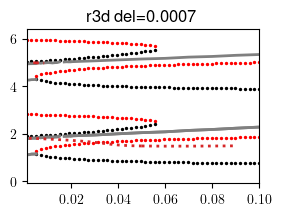

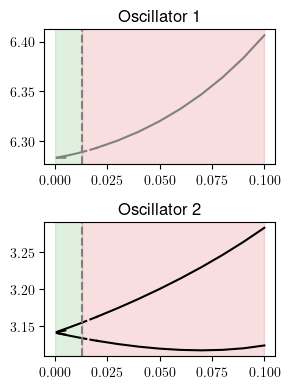

In [100]:
quick_plot_combined(a12_p0007,
                    kw_f={'data_list':data_p0007_list},
                    kw_r3d={'data_list':data_r3d_p0007_list},
                    kw_r={'etup':etup12})